Imports

In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import os

Device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Plot functions

In [3]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Class to manage configuration

In [4]:
class Config():
    training_dir = "images/training" #path to the training directory
    testing_dir =  "images/testing" #path to the testing directory
    train_batch_size = 64

Generates image pairs --> 0 for geniune pair and 1 for imposter pair

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [6]:
folder_dataset = dset.ImageFolder(root=Config.training_dir) #training dataset


Custom datasets

In [7]:
siamese_dataset_128x128_1 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((128, 128)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)

siamese_dataset_32x32_1 = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((32,32)),
                                                                      transforms.ToTensor()
                                                                      ]) ,should_invert=False)


Train dataloaders

In [8]:
train_dataloader_128x128_1 = DataLoader(siamese_dataset_128x128_1,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

train_dataloader_32x32_1 = DataLoader(siamese_dataset_32x32_1,
                        shuffle=True,
                        batch_size=Config.train_batch_size)

Visualization image pairs --> 1 indiciates dissimilar, and 0 indicates similar

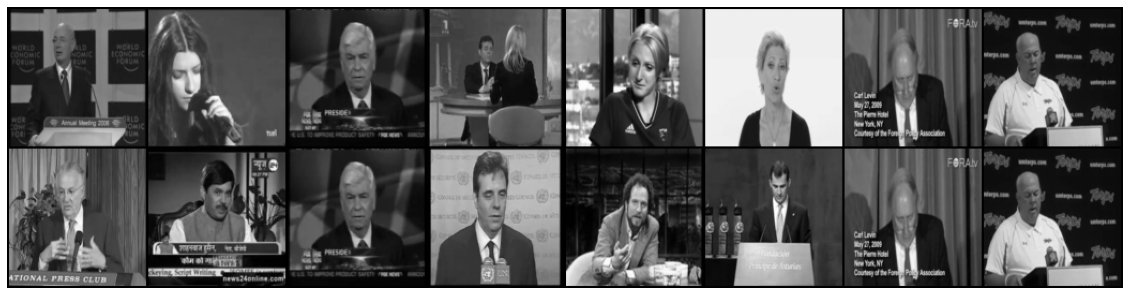

[1. 1. 0. 0. 1. 1. 0. 0.]


In [9]:
vis_dataloader = DataLoader(siamese_dataset_128x128_1,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8
)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.figure(figsize=[20, 20])
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Siamese models

In [10]:
class SiameseNetwork128x128(nn.Module):
    def __init__(self):
        super(SiameseNetwork128x128, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =43264, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

In [12]:
class SiameseNetwork32x32(nn.Module):
    def __init__(self):
        super(SiameseNetwork32x32, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels=96, kernel_size=(11,11), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size=(5,5), stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= (3,3), stride=2),
            nn.Dropout2d(p= 0.3),

            nn.Conv2d(in_channels = 256, out_channels =384, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels =384, out_channels= 256, kernel_size=(3,3), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(3,3), stride=2),
            nn.Dropout2d(p=0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features =256, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(in_features=1024, out_features=128),
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=128, out_features=15),
            nn.Sigmoid())

    #2 forward functions

    def forward_once(self, x):
        output = self.cnn1(x).cuda()
        output = output.view(output.size()[0], -1).cuda()
        output = self.fc1(output).cuda()
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1).cuda()
        output2 = self.forward_once(input2).cuda()
        return output1, output2

Loss function

In [13]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

Train function

In [30]:
def train(device, siamese_model, epochs, optimizer, loss_function, train_dataloader, save):
    counter = []
    loss_history = [] 
    iteration_number= 0
    best_loss = 100
    for epoch in tqdm(range(0,epochs)):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data #data is 2 images and a label
            
            img0, img1 , label = img0.to(device), img1.to(device), label.to(device) #push to gpu
            
            optimizer.zero_grad() #zero gradients for every batch
            
            output1,output2 = siamese_model(img0,img1) #pass 2 images in the network and obtain two outputs
            
            loss = loss_function(output1,output2,label) #compute loss for both outputs and the label
            
            loss.backward() #compute gradients
            
            optimizer.step() #adjust learning weights
            
            if i %len(train_dataloader) == 0 : #gather data and report progress
                print("Epoch number {}: Current loss {}".format(epoch, loss.item()))
                if loss.item() < best_loss:
                    torch.save(siamese_model.state_dict(), save)
                    best_loss = loss.item()
                    
                iteration_number +=1
                counter.append(iteration_number)
                loss_history.append(loss.item())

    show_plot(counter,loss_history)

In [15]:
siamese_model128x128 = SiameseNetwork128x128().to(device)
siamese_model32x32 = SiameseNetwork32x32().to(device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 1.8026360273361206


  7%|▋         | 1/15 [00:07<01:47,  7.70s/it]

Epoch number 1: Current loss 1.0309598445892334


 13%|█▎        | 2/15 [00:14<01:33,  7.23s/it]

Epoch number 2: Current loss 0.9008002281188965


 20%|██        | 3/15 [00:21<01:24,  7.08s/it]

Epoch number 3: Current loss 0.5755781531333923


 27%|██▋       | 4/15 [00:28<01:16,  6.97s/it]

Epoch number 4: Current loss 0.9368420839309692


 33%|███▎      | 5/15 [00:34<01:08,  6.82s/it]

Epoch number 5: Current loss 0.948813259601593


 40%|████      | 6/15 [00:41<00:59,  6.62s/it]

Epoch number 6: Current loss 1.0562617778778076


 47%|████▋     | 7/15 [00:47<00:51,  6.49s/it]

Epoch number 7: Current loss 0.898740291595459


 53%|█████▎    | 8/15 [00:53<00:45,  6.53s/it]

Epoch number 8: Current loss 1.3528789281845093


 60%|██████    | 9/15 [01:00<00:39,  6.56s/it]

Epoch number 9: Current loss 1.962094783782959


 67%|██████▋   | 10/15 [01:06<00:32,  6.52s/it]

Epoch number 10: Current loss 2.3281192779541016


 73%|███████▎  | 11/15 [01:13<00:26,  6.55s/it]

Epoch number 11: Current loss 2.4062464237213135


 80%|████████  | 12/15 [01:20<00:19,  6.56s/it]

Epoch number 12: Current loss 1.6212483644485474


 87%|████████▋ | 13/15 [01:26<00:13,  6.54s/it]

Epoch number 13: Current loss 1.919706106185913


 93%|█████████▎| 14/15 [01:33<00:06,  6.53s/it]

Epoch number 14: Current loss 2.0377261638641357


100%|██████████| 15/15 [01:39<00:00,  6.65s/it]


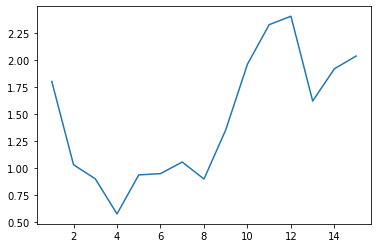

In [32]:
network128x128 = train(device, siamese_model128x128, 15, optim.Adam(siamese_model128x128.parameters()) , ContrastiveLoss(), train_dataloader_128x128_1, 'savepath/128x128.pth' )

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch number 0: Current loss 2.106454372406006


  7%|▋         | 1/15 [00:05<01:14,  5.33s/it]

Epoch number 1: Current loss 1.8124926090240479


 13%|█▎        | 2/15 [00:10<01:09,  5.35s/it]

Epoch number 2: Current loss 1.7052042484283447


 20%|██        | 3/15 [00:16<01:03,  5.33s/it]

Epoch number 3: Current loss 1.0129027366638184


 27%|██▋       | 4/15 [00:21<00:58,  5.33s/it]

Epoch number 4: Current loss 0.7519245147705078


 33%|███▎      | 5/15 [00:26<00:52,  5.25s/it]

Epoch number 5: Current loss 1.0815041065216064


 40%|████      | 6/15 [00:31<00:47,  5.25s/it]

Epoch number 6: Current loss 0.6185061931610107


 47%|████▋     | 7/15 [00:36<00:42,  5.27s/it]

Epoch number 7: Current loss 0.94744473695755


 53%|█████▎    | 8/15 [00:42<00:36,  5.27s/it]

Epoch number 8: Current loss 0.8436956405639648


 60%|██████    | 9/15 [00:47<00:31,  5.25s/it]

Epoch number 9: Current loss 0.6535000801086426


 67%|██████▋   | 10/15 [00:52<00:26,  5.27s/it]

Epoch number 10: Current loss 0.8665531873703003


 73%|███████▎  | 11/15 [00:57<00:20,  5.24s/it]

Epoch number 11: Current loss 0.8500363826751709


 80%|████████  | 12/15 [01:03<00:15,  5.23s/it]

Epoch number 12: Current loss 0.7842739820480347


 87%|████████▋ | 13/15 [01:08<00:10,  5.28s/it]

Epoch number 13: Current loss 0.6022082567214966


 93%|█████████▎| 14/15 [01:13<00:05,  5.28s/it]

Epoch number 14: Current loss 0.7729242444038391


100%|██████████| 15/15 [01:19<00:00,  5.28s/it]


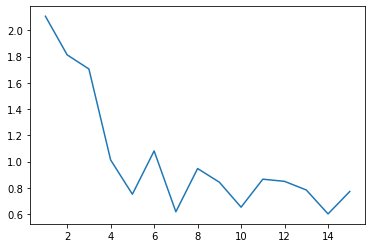

In [34]:
network32x32 = train(device, siamese_model32x32, 15, optim.Adam(siamese_model32x32.parameters()) , ContrastiveLoss(), train_dataloader_32x32_1, 'savepath/32x32.pth' )